## Неделя 2. Вторник 
### Обучение с учителем

### Применение ансаблей моделей для задач классификации и регрессии

1. Загружаем предобработанный датасет (либо загружаем и очищаем, если не осталось сохраненной версии)

In [123]:
# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import accuracy_score


# tunning hyperparamters model
import optuna

from sklearn.preprocessing import LabelEncoder, StandardScaler

In [124]:
# Загружаем предобработанные датасеты
df_train = pd.read_csv('aux/X_train_imputed.csv')
df_valid = pd.read_csv('aux/X_valid_imputed.csv')

# Отделяем признаки и целевую переменную
X_train = df_train.drop('HeartDisease', axis=1)
y_train = df_train['HeartDisease']

X_valid = df_valid.drop('HeartDisease', axis=1)
y_valid = df_valid['HeartDisease']


# Кодируем пол как числовой признак (например, M=0, F=1)
X_train['Sex'] = X_train['Sex'].map({'M': 0, 'F': 1})
X_valid['Sex'] = X_valid['Sex'].map({'M': 0, 'F': 1})

# Обновляем списки признаков: теперь Sex — числовой
num_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex']
# Категориальные признаки
cat_features = ['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Пайплайны
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_onehot_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Label Encoding категорий вручную
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_valid[col] = le.transform(X_valid[col])
    label_encoders[col] = le  # можно сохранить, если понадобится

# Теперь все признаки числовые
num_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex'] + cat_features

# Пайплайн — масштабируем только числовые признаки (без категорий, т.к. это метки)
# Можно масштабировать все, но для категорий — не обязательно и даже вредно.
# Поэтому масштабируем только числовые (без категорий)
num_only_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_only_features)
], remainder='passthrough')  # остальные признаки (категории) без изменений

2. К прежним датасетам применяем ансамбли моделей: 
    - `RandomForest`
    - `Voting`
    - `Catboost`([https://catboost.ai/en/docs/concepts/python-installation](https://catboost.ai/en/docs/concepts/python-installation))
    - `LightGBM`([https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html))
    - `XGBoost` ([https://xgboost.readthedocs.io/en/latest/install.html](https://xgboost.readthedocs.io/en/latest/install.html))

In [ ]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Модели
rf = RandomForestClassifier(random_state=42)
cat = CatBoostClassifier(random_state=42, verbose=0)
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# Ансамбль
voting_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('voting', VotingClassifier(estimators=[
        ('rf', rf),
        ('cat', cat),
        ('lgbm', lgbm),
        ('xgb', xgb)
    ], voting='soft'))
])

# Обучение
voting_clf.fit(X_train, y_train)

# Оценка
print("Voting Classifier Accuracy:", voting_clf.score(X_valid, y_valid))


[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553134 -> initscore=0.213340
[LightGBM] [Info] Start training from score 0.213340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

# ❓
Какие значения по умолчанию заданы в случайном лесе для числа деревьев и их глубины?

В RandomForestClassifier из scikit-learn значения по умолчанию следующие:

n_estimators — количество деревьев
По умолчанию: 100
То есть лес состоит из 100 деревьев, если не указали другое

max_depth — максимальная глубина каждого дерева
По умолчанию: None
Это значит, что дерево будет расти до тех пор, пока: не достигнет чистых листьев (один класс) или пока не закончится минимум по выборке (например, min_samples_split=2).
Такая глубина может привести к переобучению, особенно на шумных или небольших датасетах

3. Прогоните модели через `optuna`, определяем лучшие параметры и сохраняем результат в словарь вида:
    ```python
    results = {'model_name' : best_result}
    ```

Типичные параметры для оптимизации градиентного бустинга: 
* число итераций алгоритма
* глубина деревьев
* скорость обучения (`learning_rate`). 
Чтобы попробовать оптимизировать модели, стоит обратиться к документации: разные реализации будут предлагать разные варианты параметров. 

   > Для классификации используем метрику `accuracy_score`

In [127]:
results = {}

# Оптимизация для CatBoost
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_seed': 42,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return accuracy_score(y_valid, preds)

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_catboost, n_trials=30)
results['CatBoost'] = study_cat.best_trial.value
print("Best CatBoost Accuracy:", study_cat.best_trial.value)

# Оптимизация для LightGBM
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_state': 42,
        'verbosity': -1,
        'objective': 'binary'
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return accuracy_score(y_valid, preds)

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=30)
results['LightGBM'] = study_lgbm.best_trial.value
print("Best LightGBM Accuracy:", study_lgbm.best_trial.value)

# Оптимизация для XGBoost
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return accuracy_score(y_valid, preds)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)
results['XGBoost'] = study_xgb.best_trial.value
print("Best XGBoost Accuracy:", study_xgb.best_trial.value)

# Оптимизация для RandomForest (чтобы было)
from sklearn.ensemble import RandomForestClassifier

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'random_state': 42
    }
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return accuracy_score(y_valid, preds)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)
results['RandomForest'] = study_rf.best_trial.value
print("Best RandomForest Accuracy:", study_rf.best_trial.value)

print("Все результаты:", results)



[I 2025-10-07 16:43:15,481] A new study created in memory with name: no-name-716ce7d3-08c8-473d-9c7a-8b5ed32f404c
[I 2025-10-07 16:43:17,073] Trial 0 finished with value: 0.8695652173913043 and parameters: {'iterations': 320, 'depth': 10, 'learning_rate': 0.05390813324164266}. Best is trial 0 with value: 0.8695652173913043.
[I 2025-10-07 16:43:17,277] Trial 1 finished with value: 0.875 and parameters: {'iterations': 282, 'depth': 4, 'learning_rate': 0.1689106652605104}. Best is trial 1 with value: 0.875.
[I 2025-10-07 16:43:17,570] Trial 2 finished with value: 0.907608695652174 and parameters: {'iterations': 178, 'depth': 8, 'learning_rate': 0.20362023935166823}. Best is trial 2 with value: 0.907608695652174.
[I 2025-10-07 16:43:17,718] Trial 3 finished with value: 0.8695652173913043 and parameters: {'iterations': 212, 'depth': 3, 'learning_rate': 0.08683161865505164}. Best is trial 2 with value: 0.907608695652174.
[I 2025-10-07 16:43:17,825] Trial 4 finished with value: 0.880434782608

Best CatBoost Accuracy: 0.9130434782608695


[I 2025-10-07 16:43:29,048] Trial 2 finished with value: 0.8695652173913043 and parameters: {'n_estimators': 244, 'max_depth': 8, 'learning_rate': 0.19754857536194362}. Best is trial 0 with value: 0.8804347826086957.
[I 2025-10-07 16:43:29,166] Trial 3 finished with value: 0.8804347826086957 and parameters: {'n_estimators': 137, 'max_depth': 8, 'learning_rate': 0.15758649245576412}. Best is trial 0 with value: 0.8804347826086957.
[I 2025-10-07 16:43:29,278] Trial 4 finished with value: 0.8641304347826086 and parameters: {'n_estimators': 247, 'max_depth': 15, 'learning_rate': 0.276015129508446}. Best is trial 0 with value: 0.8804347826086957.
[I 2025-10-07 16:43:29,331] Trial 5 finished with value: 0.8532608695652174 and parameters: {'n_estimators': 230, 'max_depth': 4, 'learning_rate': 0.2282487802759968}. Best is trial 0 with value: 0.8804347826086957.
[I 2025-10-07 16:43:29,497] Trial 6 finished with value: 0.8478260869565217 and parameters: {'n_estimators': 337, 'max_depth': 9, 'lea

Best LightGBM Accuracy: 0.8913043478260869


[I 2025-10-07 16:43:32,689] Trial 0 finished with value: 0.8478260869565217 and parameters: {'n_estimators': 468, 'max_depth': 12, 'learning_rate': 0.2493373538576053}. Best is trial 0 with value: 0.8478260869565217.
/home/ninakhay/miniforge3/envs/phase1-29.09/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:43:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-10-07 16:43:33,507] Trial 1 finished with value: 0.8641304347826086 and parameters: {'n_estimators': 223, 'max_depth': 14, 'learning_rate': 0.2673726367257819}. Best is trial 1 with value: 0.8641304347826086.
/home/ninakhay/miniforge3/envs/phase1-29.09/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:43:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-10-07 16:43:34,128] Trial 2 finished with 

Best XGBoost Accuracy: 0.8804347826086957


[I 2025-10-07 16:44:01,022] Trial 0 finished with value: 0.8913043478260869 and parameters: {'n_estimators': 225, 'max_depth': 19, 'min_samples_split': 8}. Best is trial 0 with value: 0.8913043478260869.
[I 2025-10-07 16:44:01,236] Trial 1 finished with value: 0.8913043478260869 and parameters: {'n_estimators': 146, 'max_depth': 6, 'min_samples_split': 7}. Best is trial 0 with value: 0.8913043478260869.
[I 2025-10-07 16:44:01,437] Trial 2 finished with value: 0.8858695652173914 and parameters: {'n_estimators': 122, 'max_depth': 14, 'min_samples_split': 4}. Best is trial 0 with value: 0.8913043478260869.
[I 2025-10-07 16:44:01,702] Trial 3 finished with value: 0.8913043478260869 and parameters: {'n_estimators': 205, 'max_depth': 3, 'min_samples_split': 9}. Best is trial 0 with value: 0.8913043478260869.
[I 2025-10-07 16:44:01,824] Trial 4 finished with value: 0.8913043478260869 and parameters: {'n_estimators': 77, 'max_depth': 10, 'min_samples_split': 8}. Best is trial 0 with value: 0.8

Best RandomForest Accuracy: 0.9021739130434783
Все результаты: {'CatBoost': 0.9130434782608695, 'LightGBM': 0.8913043478260869, 'XGBoost': 0.8804347826086957, 'RandomForest': 0.9021739130434783}


4. Превращаем словарь в `DataFrame` и сравниваем полученные результаты. Строим `bar_plot` для визуализации метрики качества. 

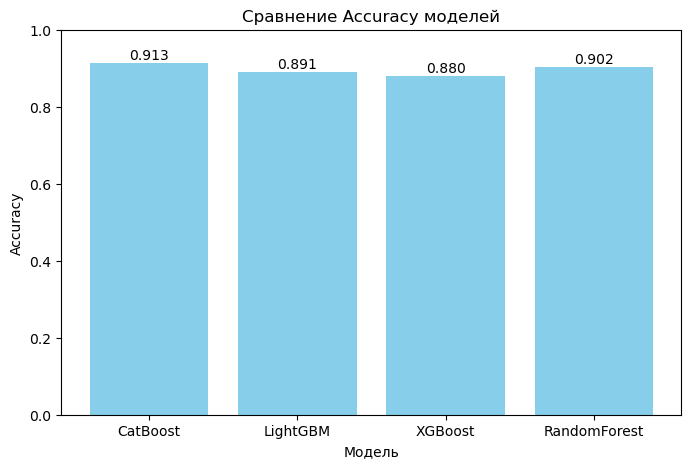

In [128]:
results = {'CatBoost': 0.9130434782608695, 
           'LightGBM': 0.8913043478260869, 
           'XGBoost': 0.8804347826086957, 
           'RandomForest': 0.9021739130434783}

df_results = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])


plt.figure(figsize=(8,5))
plt.bar(df_results['Model'], df_results['Accuracy'], color='skyblue')
plt.title('Сравнение Accuracy моделей')
plt.xlabel('Модель')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(df_results['Accuracy']):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)
plt.show()


5. Выберете лучшую модель и попробуйте задеплоить ее в Streamlit.

* Создайте просто интерфейс для пользователя, куда бы он мог ввести необходимые данные, а вы бы ему вернули предсказание

In [129]:
import joblib
import streamlit as st

In [131]:
import joblib
import streamlit as st

catboost_model = CatBoostClassifier(random_seed=42, verbose=0)
catboost_model.fit(X_train, y_train)
joblib.dump(catboost_model, 'catboost_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')




['label_encoders.pkl']